'\nBarış Nişancı\n20070001019\n'

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and prepare the dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trn_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
vld_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
tst_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training set into training and validation partitions
trn_size = int(0.8 * len(trn_dataset))
vld_size = len(trn_dataset) - trn_size
torch.manual_seed(0)
trn_dataset, vld_dataset = random_split(trn_dataset, [trn_size, vld_size])

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
num_classes = len(classes)

batch_size = 32
trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
vld_loader = DataLoader(vld_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
tst_loader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model_predictions(model, loader=tst_loader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: ' + classes[preds[j]])
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

100%|██████████| 170498071/170498071 [00:01<00:00, 92874765.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
"""
Question 1
"""

In [2]:
# Bottleneck Residual Block
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [3]:
# ResNet Model using Bottleneck blocks
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [4]:
def print_model_summary(model, input_size):
    def get_num_params(model):
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        return total_params, trainable_params

    print("Model Summary")
    print("-------------")
    print(model)
    print("Input Size:", input_size)
    total_params, trainable_params = get_num_params(model)
    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")

model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes).to(device)
input_size = (batch_size, 3, 224, 224)
print_model_summary(model, input_size)

Model Summary
-------------
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ker

Epoch 1/10
----------
Training Loss: 1.9149 Accuracy: 30.86% Val Loss: 1.6450 Accuracy: 41.12%
Epoch 2/10
----------
Training Loss: 1.4095 Accuracy: 48.47% Val Loss: 1.3241 Accuracy: 53.04%
Epoch 3/10
----------
Training Loss: 1.1288 Accuracy: 59.45% Val Loss: 1.2130 Accuracy: 61.52%
Epoch 4/10
----------
Training Loss: 0.9450 Accuracy: 66.44% Val Loss: 0.9807 Accuracy: 66.81%
Epoch 5/10
----------
Training Loss: 0.8118 Accuracy: 71.42% Val Loss: 0.9663 Accuracy: 68.35%
Epoch 6/10
----------
Training Loss: 0.6996 Accuracy: 75.48% Val Loss: 0.8810 Accuracy: 73.42%
Epoch 7/10
----------
Training Loss: 0.5978 Accuracy: 78.99% Val Loss: 0.8483 Accuracy: 71.69%
Epoch 8/10
----------
Training Loss: 0.5144 Accuracy: 82.11% Val Loss: 0.9860 Accuracy: 73.88%
Epoch 9/10
----------
Training Loss: 0.4360 Accuracy: 84.77% Val Loss: 0.9388 Accuracy: 72.31%
Epoch 10/10
----------
Training Loss: 0.3683 Accuracy: 87.01% Val Loss: 0.8566 Accuracy: 74.45%


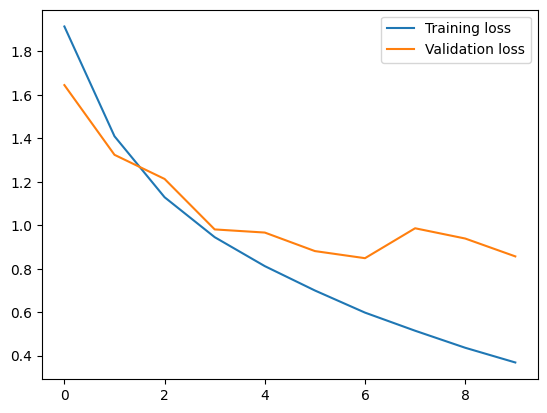

Accuracy of the network on the 10000 test images: 74.93 %


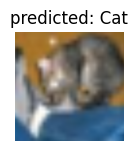

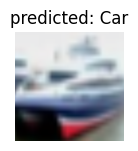

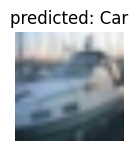

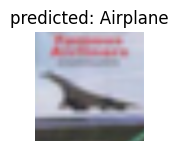

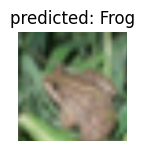

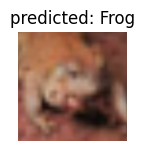

Model Summary
-------------
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ker

In [5]:
# Training and evaluation
model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

num_epochs = 10

# Train the model
def train_model(model, criterion, optimizer, num_epochs=20):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trn_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trn_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_accuracy = 100 * correct_train / total_train
        train_acc_history.append(train_accuracy)

        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in vld_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(vld_loader.dataset)
        val_loss_history.append(epoch_loss)
        val_accuracy = 100 * correct_val / total_val
        val_acc_history.append(val_accuracy)

        print(f'Training Loss: {train_loss_history[-1]:.4f} Accuracy: {train_acc_history[-1]:.2f}% Val Loss: {val_loss_history[-1]:.4f} Accuracy: {val_acc_history[-1]:.2f}%')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, num_epochs)


# Plot learning and generalization curves
plt.figure()
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in tst_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

# Visualize some predictions
visualize_model_predictions(model, tst_loader)

# Model summary
print_model_summary(model, input_size)

In [ ]:
"""
Question 2.a
"""

Epoch 1/10
----------
Training Loss: 1.0984 Accuracy: 61.32% Val Loss: 1.0269 Accuracy: 67.39%
Epoch 2/10
----------
Training Loss: 0.8622 Accuracy: 70.11% Val Loss: 1.1382 Accuracy: 70.89%
Epoch 3/10
----------
Training Loss: 0.7598 Accuracy: 73.55% Val Loss: 0.7508 Accuracy: 74.31%
Epoch 4/10
----------
Training Loss: 0.6754 Accuracy: 76.68% Val Loss: 0.6675 Accuracy: 77.01%
Epoch 5/10
----------
Training Loss: 0.6150 Accuracy: 78.67% Val Loss: 0.6860 Accuracy: 77.31%
Epoch 6/10
----------
Training Loss: 0.5596 Accuracy: 80.61% Val Loss: 0.6452 Accuracy: 77.63%
Epoch 7/10
----------
Training Loss: 0.5010 Accuracy: 82.59% Val Loss: 0.6306 Accuracy: 78.72%
Epoch 8/10
----------
Training Loss: 0.4530 Accuracy: 84.48% Val Loss: 0.5300 Accuracy: 81.84%
Epoch 9/10
----------
Training Loss: 0.4127 Accuracy: 85.75% Val Loss: 0.5510 Accuracy: 81.05%
Epoch 10/10
----------
Training Loss: 0.3729 Accuracy: 87.23% Val Loss: 0.5612 Accuracy: 81.16%


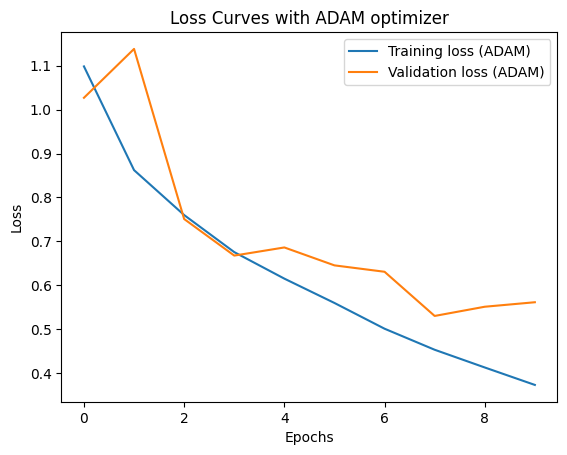

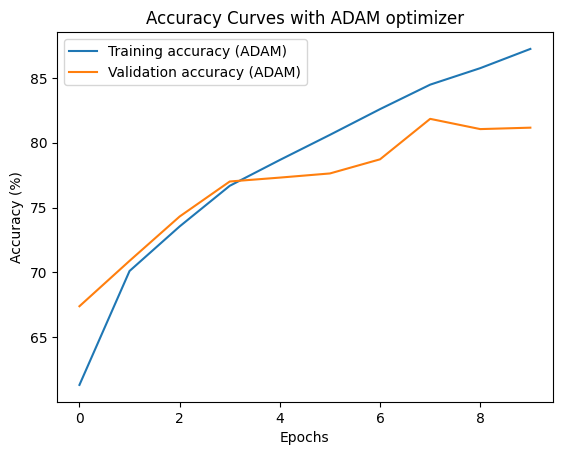

In [6]:
# ADAM optimizer with weight decay
optimizer_adam = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the model with ADAM optimizer
train_loss_adam, val_loss_adam, train_acc_adam, val_acc_adam = train_model(model, criterion, optimizer_adam, num_epochs)

# Plot learning and generalization curves for ADAM
plt.figure()
plt.plot(train_loss_adam, label='Training loss (ADAM)')
plt.plot(val_loss_adam, label='Validation loss (ADAM)')
plt.legend()
plt.title('Loss Curves with ADAM optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(train_acc_adam, label='Training accuracy (ADAM)')
plt.plot(val_acc_adam, label='Validation accuracy (ADAM)')
plt.legend()
plt.title('Accuracy Curves with ADAM optimizer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

In [ ]:
"""
Question 2.b
"""

Epoch 1/10
----------
Training Loss: 1.7169 Accuracy: 36.60% Val Loss: 1.5277 Accuracy: 45.22%
Learning Rate: 0.001
Epoch 2/10
----------
Training Loss: 1.2013 Accuracy: 56.38% Val Loss: 1.1833 Accuracy: 57.00%
Learning Rate: 0.001
Epoch 3/10
----------
Training Loss: 0.9959 Accuracy: 64.59% Val Loss: 0.9459 Accuracy: 66.60%
Learning Rate: 0.001
Epoch 4/10
----------
Training Loss: 0.8811 Accuracy: 68.91% Val Loss: 1.0477 Accuracy: 63.39%
Learning Rate: 0.001
Epoch 5/10
----------
Training Loss: 0.7791 Accuracy: 72.72% Val Loss: 0.8093 Accuracy: 71.95%
Learning Rate: 0.001
Epoch 6/10
----------
Training Loss: 0.6937 Accuracy: 75.79% Val Loss: 0.7175 Accuracy: 74.64%
Learning Rate: 0.001
Epoch 7/10
----------
Training Loss: 0.6270 Accuracy: 78.25% Val Loss: 0.7162 Accuracy: 75.53%
Learning Rate: 0.001
Epoch 8/10
----------
Training Loss: 0.5757 Accuracy: 79.91% Val Loss: 0.6281 Accuracy: 77.90%
Learning Rate: 0.001
Epoch 9/10
----------
Training Loss: 0.5236 Accuracy: 81.72% Val Loss: 0

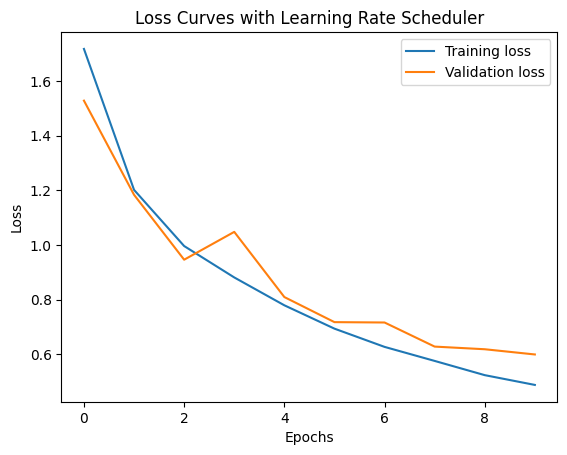

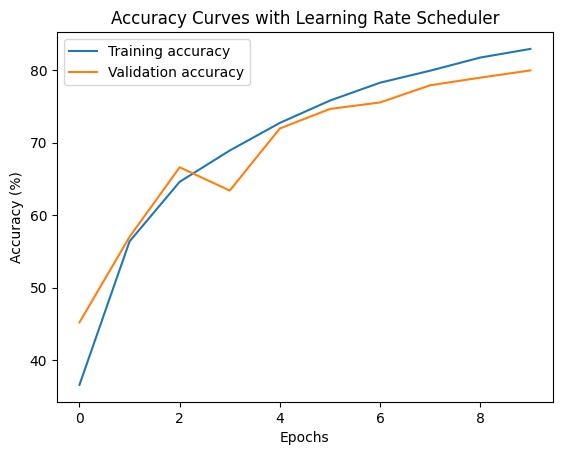

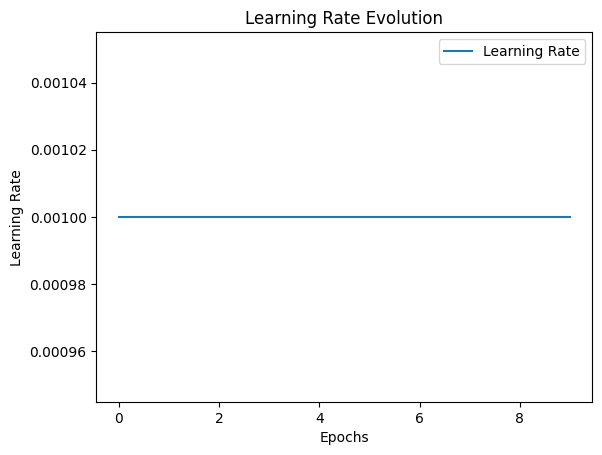

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Train the model with learning rate scheduling
def train_model_with_scheduler(model, criterion, optimizer, num_epochs=20):
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=1, verbose=True)

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    lr_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trn_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trn_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_accuracy = 100 * correct_train / total_train
        train_acc_history.append(train_accuracy)

        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in vld_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(vld_loader.dataset)
        val_loss_history.append(epoch_loss)
        val_accuracy = 100 * correct_val / total_val
        val_acc_history.append(val_accuracy)

        scheduler.step(val_accuracy)
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)

        print(f'Training Loss: {train_loss_history[-1]:.4f} Accuracy: {train_acc_history[-1]:.2f}% Val Loss: {val_loss_history[-1]:.4f} Accuracy: {val_acc_history[-1]:.2f}%')
        print(f'Learning Rate: {current_lr}')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, lr_history

# Ensure model is re-initialized before retraining
model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes).to(device)

# ADAM optimizer with weight decay
optimizer_adam = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the model with ADAM optimizer and learning rate scheduler
train_loss_sched, val_loss_sched, train_acc_sched, val_acc_sched, lr_history = train_model_with_scheduler(model, criterion, optimizer_adam, num_epochs)

# Plot learning and generalization curves with scheduler
plt.figure()
plt.plot(train_loss_sched, label='Training loss')
plt.plot(val_loss_sched, label='Validation loss')
plt.legend()
plt.title('Loss Curves with Learning Rate Scheduler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(train_acc_sched, label='Training accuracy')
plt.plot(val_acc_sched, label='Validation accuracy')
plt.legend()
plt.title('Accuracy Curves with Learning Rate Scheduler')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

# Plot learning rate evolution
plt.figure()
plt.plot(lr_history, label='Learning Rate')
plt.legend()
plt.title('Learning Rate Evolution')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show()


In [ ]:
"""
Question 3
"""

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


Epoch 1/10
----------
Training Loss: 0.8789 Accuracy: 70.04% Val Loss: 0.6957 Accuracy: 75.98%
Learning Rate: 0.001
Epoch 2/10
----------
Training Loss: 0.7162 Accuracy: 75.48% Val Loss: 0.6699 Accuracy: 76.93%
Learning Rate: 0.001
Epoch 3/10
----------
Training Loss: 0.6855 Accuracy: 76.38% Val Loss: 0.6340 Accuracy: 78.27%
Learning Rate: 0.001
Epoch 4/10
----------
Training Loss: 0.6681 Accuracy: 77.06% Val Loss: 0.6260 Accuracy: 78.63%
Learning Rate: 0.001
Epoch 5/10
----------
Training Loss: 0.6583 Accuracy: 77.34% Val Loss: 0.6297 Accuracy: 78.39%
Learning Rate: 0.001
Epoch 6/10
----------
Training Loss: 0.6351 Accuracy: 78.23% Val Loss: 0.6597 Accuracy: 77.46%
Learning Rate: 0.001
Epoch 7/10
----------
Training Loss: 0.6334 Accuracy: 78.15% Val Loss: 0.6193 Accuracy: 78.81%
Learning Rate: 0.001
Epoch 8/10
----------
Training Loss: 0.6216 Accuracy: 78.55% Val Loss: 0.6269 Accuracy: 78.74%
Learning Rate: 0.001
Epoch 9/10
----------
Training Loss: 0.6113 Accuracy: 78.82% Val Loss: 0

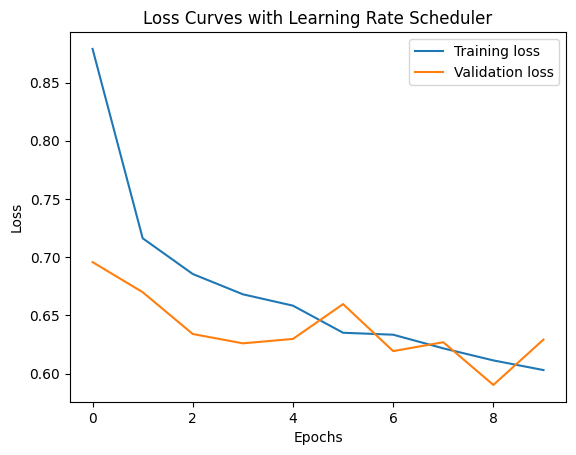

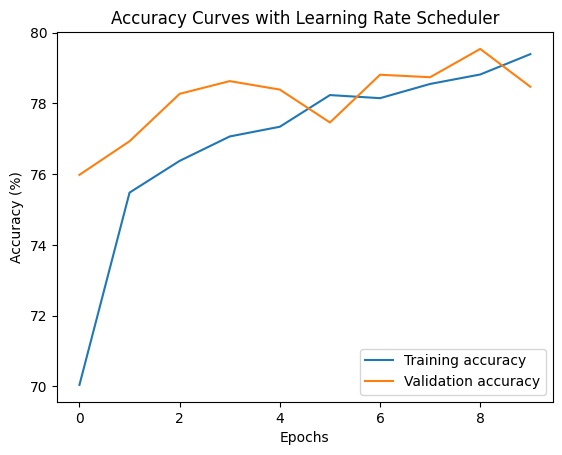

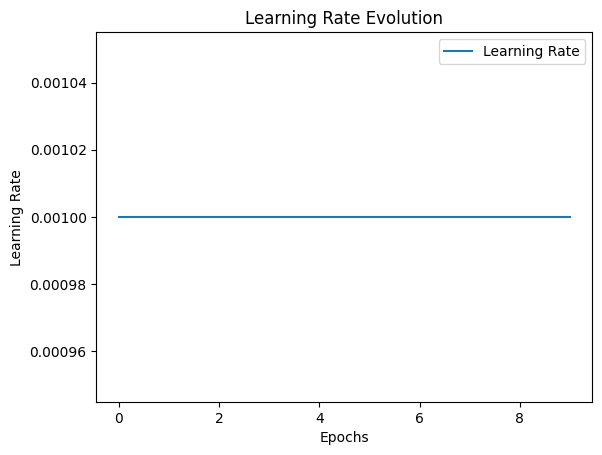

Accuracy of the network on the 10000 test images: 78.46%


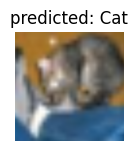

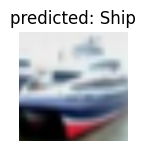

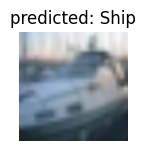

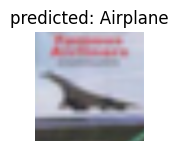

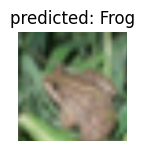

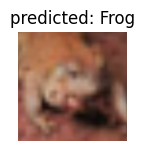

Model Summary
-------------
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ker

In [11]:
from torchvision import models

# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Freeze all the layers
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer for CIFAR-10 classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)  # num_classes is 10 for CIFAR-10

# By default, the new fully connected layer is trainable
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=2, verbose=True)

# Training function with learning rate scheduler
def train_model_with_scheduler(model, criterion, optimizer, scheduler, num_epochs=10):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    lr_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trn_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trn_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_accuracy = 100 * correct_train / total_train
        train_acc_history.append(train_accuracy)

        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in vld_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(vld_loader.dataset)
        val_loss_history.append(epoch_loss)
        val_accuracy = 100 * correct_val / total_val
        val_acc_history.append(val_accuracy)

        scheduler.step(val_accuracy)
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)

        print(f'Training Loss: {train_loss_history[-1]:.4f} Accuracy: {train_acc_history[-1]:.2f}% Val Loss: {val_loss_history[-1]:.4f} Accuracy: {val_acc_history[-1]:.2f}%')
        print(f'Learning Rate: {current_lr}')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, lr_history

# Train the model with ADAM optimizer and learning rate scheduler
train_loss, val_loss, train_acc, val_acc, lr_history = train_model_with_scheduler(model, criterion, optimizer, scheduler, num_epochs=10)

# Plot learning and generalization curves with scheduler
plt.figure()
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.title('Loss Curves with Learning Rate Scheduler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend()
plt.title('Accuracy Curves with Learning Rate Scheduler')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

# Plot learning rate evolution
plt.figure()
plt.plot(lr_history, label='Learning Rate')
plt.legend()
plt.title('Learning Rate Evolution')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show()

# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in tst_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

# Visualize some predictions
visualize_model_predictions(model, tst_loader)

# Print model summary
print_model_summary(model, input_size)
